# 用飞桨框架2.0造一个会下五子棋的AI模型

作者信息：yangguohao (https://github.com/yangguohao/)

更新日期：2022 年 12 月 27 日

## 1. 简要介绍

### AlphaZero

* 在 AlphaZero 之前还有过两代版本，分别为 AlphaGo 和 AlphaGoZero 。而 AlphaZero 是 ALphaGoZero 的升级版本。

* 作为一个通用模型，AlphaZero 不只针对围棋，而是同时学习了三种棋类，日本将棋、国际象棋以及围棋。从零开始，经过短时间的训练，AlphaZero 完胜各个领域里的最强AI。包括国际象棋的Stockfish，将棋的Elmo，以及围棋的前辈AlphaGo Zero。其核心主要为 MCTS 和 策略价值深度网络。

![](https://ai-studio-static-online.cdn.bcebos.com/abb79e88765242ccb9df65f2cf4877fc83be041546bf47e293dcae1b98e7e8bb)


### 本项目简介

* 本项目是AlphaZero算法的一个实现（使用PaddlePaddle框架），用于玩简单的棋盘游戏Gomoku（也称为五子棋），使用纯粹的自我博弈的方式开始训练。

* Gomoku游戏比围棋或象棋简单得多，因此我们可以专注于AlphaZero的训练，在一台PC机上几个小时内就可以获得一个让你不可忽视的AI模型。

![](https://ai-studio-static-online.cdn.bcebos.com/bb8cea51f3eb498291058e5f34784dce618581cd0aa0499cbcc10d347ecde660)

* 因为和围棋相比，五子棋的规则较为简单，落子空间也比较小，因此没有用到AlphaGo Zero中大量使用的残差网络，只使用了卷积层和全连接层。本项目的网路简单，无需使用大量的计算就可以进行运行训练。使用的 Paddle 版本为 2.4.0


## 2. 环境配置
本教程基于 PaddlePaddle 2.4.0 编写，如果你的环境不是本版本，请先参考官网安装 PaddlePaddle 2.4.0。

In [1]:
!pip install pygame

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import random
import copy
import os
import time
from collections import defaultdict, deque
from operator import itemgetter


import paddle
import paddle.nn as nn 
import paddle.nn.functional as F

# 可视化等
import pygame
from pygame.locals import *


pygame 2.1.2 (SDL 2.0.16, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 游戏环境

初始化游戏环境，可以跳过该内容。

主要是针对五子棋棋盘大小，走子以及游戏规则的设定，以及棋盘棋子等可视化的 UI 设定。

In [3]:

# 电脑字体的位置
FONT_PATH = 'C:/Windows/Fonts/simkai.ttf'

class Board(object):
    """棋盘游戏逻辑控制"""

    def __init__(self, **kwargs):
        self.width = int(kwargs.get('width', 15))  # 棋盘宽度
        self.height = int(kwargs.get('height', 15))  # 棋盘高度
        self.states = {}    # 棋盘状态为一个字典,键: 移动步数,值: 玩家的棋子类型
        self.n_in_row = int(kwargs.get('n_in_row', 5))  # 5个棋子一条线则获胜
        self.players = [1, 2]  # 玩家1,2

    def init_board(self, start_player=0):
        # 初始化棋盘

        # 当前棋盘的宽高小于5时,抛出异常(因为是五子棋)
        if self.width < self.n_in_row or self.height < self.n_in_row:
            raise Exception('棋盘的长宽不能少于{}'.format(self.n_in_row))
        self.current_player = self.players[start_player]  # 先手玩家
        self.availables = list(range(self.width * self.height)) # 初始化可用的位置列表
        self.states = {}  # 初始化棋盘状态
        self.last_move = -1  # 初始化最后一次的移动位置

    def move_to_location(self, move):
        # 根据传入的移动步数返回位置(如:move=2,计算得到坐标为[0,2],即表示在棋盘上左上角横向第三格位置)
        h = move // self.width
        w = move % self.width
        return [h, w]

    def location_to_move(self, location):
        # 根据传入的位置返回移动值
        # 位置信息必须包含2个值[h,w]
        if len(location) != 2:
            return -1
        h = location[0]
        w = location[1]
        move = h * self.width + w
        # 超出棋盘的值不存在
        if move not in range(self.width * self.height):
            return -1
        return move

    def current_state(self):
        """
        从当前玩家的角度返回棋盘状态。
        状态形式: 4 * 宽 * 高
        """
        # 使用4个15x15的二值特征平面来描述当前的局面
        # 前两个平面分别表示当前player的棋子位置和对手player的棋子位置，有棋子的位置是1，没棋子的位置是0
        # 第三个平面表示对手player最近一步的落子位置，也就是整个平面只有一个位置是1，其余全部是0
        # 第四个平面表示的是当前player是不是先手player，如果是先手player则整个平面全部为1，否则全部为0
        square_state = np.zeros((4, self.width, self.height))
        if self.states:
            moves, players = np.array(list(zip(*self.states.items())))
            move_curr = moves[players == self.current_player]   # 获取棋盘状态上属于当前玩家的所有移动值
            move_oppo = moves[players != self.current_player]   # 获取棋盘状态上属于对方玩家的所有移动值
            square_state[0][move_curr // self.width,            # 对第一个特征平面填充值(当前玩家)
                            move_curr % self.height] = 1.0
            square_state[1][move_oppo // self.width,            # 对第二个特征平面填充值(对方玩家)
                            move_oppo % self.height] = 1.0
            # 指出最后一个移动位置
            square_state[2][self.last_move // self.width,       # 对第三个特征平面填充值(对手最近一次的落子位置)
                            self.last_move % self.height] = 1.0
        if len(self.states) % 2 == 0:   # 对第四个特征平面填充值,当前玩家是先手,则填充全1,否则为全0
            square_state[3][:, :] = 1.0
        # 将每个平面棋盘状态按行逆序转换(第一行换到最后一行,第二行换到倒数第二行..)
        return square_state[:, ::-1, :]

    def do_move(self, move):
        # 根据移动的数据更新各参数
        self.states[move] = self.current_player  # 将当前的参数存入棋盘状态中
        self.availables.remove(move)  # 从可用的棋盘列表移除当前移动的位置
        self.current_player = (
            self.players[0] if self.current_player == self.players[1]
            else self.players[1]
        )  # 改变当前玩家
        self.last_move = move  # 记录最后一次的移动位置

    def has_a_winner(self):
        # 是否产生赢家
        width = self.width  # 棋盘宽度
        height = self.height  # 棋盘高度
        states = self.states  # 状态
        n = self.n_in_row  # 获胜需要的棋子数量

        # 当前棋盘上所有的落子位置
        moved = list(set(range(width * height)) - set(self.availables))
        if len(moved) < self.n_in_row + 2:
            # 当前棋盘落子数在7个以上时会产生赢家,落子数低于7个时,直接返回没有赢家
            return False, -1

        # 遍历落子数
        for m in moved:
            h = m // width
            w = m % width  # 获得棋子的坐标
            player = states[m]  # 根据移动的点确认玩家

            # 判断各种赢棋的情况
            # 横向5个
            if (w in range(width - n + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n))) == 1):
                return True, player

            # 纵向5个
            if (h in range(height - n + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n * width, width))) == 1):
                return True, player

            # 左上到右下斜向5个
            if (w in range(width - n + 1) and h in range(height - n + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n * (width + 1), width + 1))) == 1):
                return True, player

            # 右上到左下斜向5个
            if (w in range(n - 1, width) and h in range(height - n + 1) and
                    len(set(states.get(i, -1) for i in range(m, m + n * (width - 1), width - 1))) == 1):
                return True, player

        # 当前都没有赢家,返回False
        return False, -1

    def game_end(self):
        """检查当前棋局是否结束"""
        win, winner = self.has_a_winner()
        if win:
            return True, winner
        elif not len(self.availables):
            # 棋局布满,没有赢家
            return True, -1
        return False, -1

    def get_current_player(self):
        return self.current_player

N = 9

IMAGE_PATH = 'UI/'

WIDTH = 540 # 棋盘图片宽
HEIGHT = 540    # 棋盘图片高
MARGIN = 22 # 图片上的棋盘边界有间隔
# GRID = (WIDTH - 2 * MARGIN) / (N - 1)   # 设置每个格子的大小
GRID = (270-22)/7      #设置每个格子的大小，从棋盘左上方开始下棋
PIECE = 32  # 棋子的大小

# 加上UI的布局的训练方式
class Game_UI(object):
    """游戏控制区域"""

    def __init__(self, board, is_shown, **kwargs):
        self.board = board  # 加载棋盘控制类
        self.is_shown = is_shown

        # 初始化 pygame
        pygame.init()

        if is_shown != 0:
            self.__screen = pygame.display.set_mode((WIDTH, HEIGHT), 0, 32)
            pygame.display.set_caption('五子棋AI')

            # UI 资源
            self.__ui_chessboard = pygame.image.load(IMAGE_PATH + 'chessboard.jpg').convert()
            self.__ui_piece_black = pygame.image.load(IMAGE_PATH + 'piece_black.png').convert_alpha()
            self.__ui_piece_white = pygame.image.load(IMAGE_PATH + 'piece_white.png').convert_alpha()

    # 将索引转换成坐标
    def coordinate_transform_map2pixel(self, i, j):
        # 从 逻辑坐标到 UI 上的绘制坐标的转换
        return MARGIN + j * GRID - PIECE / 2, MARGIN + i * GRID - PIECE / 2

    # 将坐标转换成索引
    def coordinate_transform_pixel2map(self, x, y):
        # 从 UI 上的绘制坐标到 逻辑坐标的转换
        i, j = int(round((y - MARGIN + PIECE / 2) / GRID)), int(round((x - MARGIN + PIECE / 2) / GRID))
        # 有MAGIN, 排除边缘位置导致 i,j 越界
        if i < 0 or i >= N or j < 0 or j >= N:
            return None, None
        else:
            return i, j

    def draw_chess(self):
        # 棋盘
        self.__screen.blit(self.__ui_chessboard, (0, 0))
        # 棋子
        for i in range(0, N):
            for j in range(0, N):
                # 计算移动位置
                loc = i * N + j
                p = self.board.states.get(loc, -1)

                player1, player2 = self.board.players

                # 求出落子的坐标
                x, y = self.coordinate_transform_map2pixel(i, j)

                if p == player1:  # 玩家为1时,将该位置放入黑棋
                    self.__screen.blit(self.__ui_piece_black, (x, y))
                elif p == player2:  # 玩家为2时,将该位置放入白棋
                    self.__screen.blit(self.__ui_piece_white, (x, y))
                else:
                    pass  # 当前位置无玩家落子时,跳过

    def one_step(self):
        i, j = None, None
        # 鼠标点击
        mouse_button = pygame.mouse.get_pressed()
        # 左键
        if mouse_button[0]:
            x, y = pygame.mouse.get_pos()
            i, j = self.coordinate_transform_pixel2map(x, y)

        if not i is None and not j is None:
            loc = i * N + j
            p = self.board.states.get(loc, -1)

            player1, player2 = self.board.players

            if p == player1 or p == player2:
                # 当前位置有棋子
                return False
            else:
                cp = self.board.current_player

                location = [i,j]
                move = self.board.location_to_move(location)
                self.board.do_move(move)

                if self.is_shown:
                    if cp == player1:
                        self.__screen.blit(self.__ui_piece_black, (x, y))
                    else:
                        self.__screen.blit(self.__ui_piece_white, (x, y))

                return True
        return False

    def draw_result(self, result):
        font = pygame.font.Font(FONT_PATH, 50)
        tips = u"本局结束:"

        player1, player2 = self.board.players

        if result == player1:
            tips = tips + u"玩家1胜利"
        elif result == player2:
            tips = tips + u"玩家2胜利"
        else:
            tips = tips + u"平局"
        text = font.render(tips, True, (255, 0, 0))
        self.__screen.blit(text, (WIDTH / 2 - 200, HEIGHT / 2 - 50))

    # 使用鼠标对弈(player1传入为人类玩家,player2为MCTS机器人)
    def start_play_mouse(self, player1, player2, start_player=0):
        """开始一局游戏"""
        if start_player not in (0, 1):
            # 如果玩家不在玩家1,玩家2之间,抛出异常
            raise Exception('开始的玩家必须为0(玩家1)或1(玩家2)')
        self.board.init_board(start_player)  # 初始化棋盘
        p1, p2 = self.board.players  # 加载玩家1,玩家2
        player1.set_player_ind(p1)  # 设置玩家1
        player2.set_player_ind(p2)  # 设置玩家2
        players = {p1: player1, p2: player2}

        # 如果人类玩家不是先手
        if start_player != 0:
            current_player = self.board.current_player  # 获取当前玩家
            player_in_turn = players[current_player]  # 当前玩家的信息
            move = player_in_turn.get_action(self.board)  # 基于MCTS的AI下一步落子
            self.board.do_move(move)  # 根据下一步落子的状态更新棋盘各参数

        if self.is_shown:
            # 绘制棋盘
            self.draw_chess()
            # 刷新
            pygame.display.update()

        flag = False
        win = None

        while True:
            # 捕捉pygame事件
            for event in pygame.event.get():
                # 退出程序
                if event.type == QUIT:
                    pygame.quit()
                    exit()
                elif event.type == MOUSEBUTTONDOWN:
                    # 成功着棋
                    if self.one_step():
                        end, winner = self.board.game_end()
                    else:
                        continue
                    # 结束
                    if end:
                        flag = True
                        win = winner
                        break

                    # 没有结束,则使用MCTS进行下一步落子
                    current_player = self.board.current_player  # 获取当前玩家
                    player_in_turn = players[current_player]  # 当前玩家的信息

                    move = player_in_turn.get_action(self.board)  # 基于MCTS的AI下一步落子
                    self.board.do_move(move)  # 根据下一步落子的状态更新棋盘各参数

                    if self.is_shown:
                        # 展示棋盘
                        self.draw_chess()
                        # 刷新
                        pygame.display.update()

                    # 判断当前棋局是否结束
                    end, winner = self.board.game_end()
                    # 结束
                    if end:
                        flag = True
                        win = winner
                        break

            if flag and self.is_shown:
                self.draw_result(win)
                # 刷新
                pygame.display.update()
                break

    def start_play(self, player1, player2, start_player=0):
        """开始一局游戏"""
        if start_player not in (0, 1):
            # 如果玩家不在玩家1,玩家2之间,抛出异常
            raise Exception('开始的玩家必须为0(玩家1)或1(玩家2)')
        self.board.init_board(start_player)  # 初始化棋盘
        p1, p2 = self.board.players  # 加载玩家1,玩家2
        player1.set_player_ind(p1)  # 设置玩家1
        player2.set_player_ind(p2)  # 设置玩家2
        players = {p1: player1, p2: player2}
        if self.is_shown:
            # 绘制棋盘
            self.draw_chess()
            # 刷新
            pygame.display.update()

        while True:
            if self.is_shown:
                # 捕捉pygame事件
                for event in pygame.event.get():
                    # 退出程序
                    if event.type == QUIT:
                        pygame.quit()
                        exit()

            current_player = self.board.current_player  # 获取当前玩家
            player_in_turn = players[current_player]  # 当前玩家的信息
            move = player_in_turn.get_action(self.board)  # 基于MCTS的AI下一步落子
            self.board.do_move(move)  # 根据下一步落子的状态更新棋盘各参数
            if self.is_shown:
                # 展示棋盘
                self.draw_chess()
                # 刷新
                pygame.display.update()

            # 判断当前棋局是否结束
            end, winner = self.board.game_end()
            # 结束
            if end:
                win = winner
                break
        if self.is_shown:
            self.draw_result(win)
            # 刷新
            pygame.display.update()
        return win

    def start_self_play(self, player, temp=1e-3):
        """ 使用MCTS玩家开始自己玩游戏,重新使用搜索树并存储自己玩游戏的数据
        (state, mcts_probs, z) 提供训练
        """
        self.board.init_board()  # 初始化棋盘
        states, mcts_probs, current_players = [], [], []  # 状态,mcts的行为概率,当前玩家

        if self.is_shown:
            # 绘制棋盘
            self.draw_chess()
            # 刷新
            pygame.display.update()

        while True:
            if self.is_shown:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        pygame.quit()
                        exit()

            # 根据当前棋盘状态返回可能得行为,及行为对应的概率
            move, move_probs = player.get_action(self.board,
                                                 temp=temp,
                                                 return_prob=1)
            # 存储数据
            states.append(self.board.current_state())  # 存储状态数据
            mcts_probs.append(move_probs)  # 存储行为概率数据
            current_players.append(self.board.current_player)  # 存储当前玩家
            # 执行一个移动
            self.board.do_move(move)
            if self.is_shown:
                # 绘制棋盘
                self.draw_chess()
                # 刷新
                pygame.display.update()

            # 判断该局游戏是否终止
            end, winner = self.board.game_end()
            if end:
                # 从每个状态的当时的玩家的角度看待赢家
                winners_z = np.zeros(len(current_players))
                if winner != -1:
                    # 没有赢家时
                    winners_z[np.array(current_players) == winner] = 1.0
                    winners_z[np.array(current_players) != winner] = -1.0
                # 重置MSCT的根节点
                player.reset_player()
                if self.is_shown:
                    self.draw_result(winner)

                    # 刷新
                    pygame.display.update()
                return winner, zip(states, mcts_probs, winners_z)


## 3. 价值策略网络

* 原论文中的策略价值网络的结构是一个 CNN 组成的神经网络，初始游戏状态的张量在经过一个基本的卷积后，使用了19层或者39层的深度残差网络，最后输出价值和策略两个部分。

![](https://ai-studio-static-online.cdn.bcebos.com/683b7ce3cbd349588557690100b4c6bce57321082918406aa801cd9ef84753d2)

* 而这里为了演示算法网络比较简单，由公共网络层、行动策略网络层和状态价值网络层构成。

* 在定义好策略和价值网络的基础上，接下来实现PolicyValueNet类，该类主要定义：policy_value_fn()方法，主要用于蒙特卡洛树搜索时评估叶子节点对应局面评分、该局所有可行动作及对应概率；另一个方法train_step()，主要用于更新自我对弈收集数据上策略价值网络的参数。

* 在训练神经网络阶段，我们使用自我对战学习阶段得到的样本集合(s,π,z),训练我们神经网络的模型参数。训练的目的是对于每个输入s, 神经网络输出的p,v和我们训练样本中的π,z差距尽可能的少。

* 损失函数由三部分组成，第一部分是均方误差损失函数，用于评估神经网络预测的胜负结果和真实结果之间的差异。第二部分是交叉熵损失函数，用于评估神经网络的输出策略和我们MCTS输出的策略的差异。第三部分是L2正则化项。

In [4]:


class Net(paddle.nn.Layer):
    def __init__(self,board_width, board_height):
        super(Net, self).__init__()
        self.board_width = board_width
        self.board_height = board_height
        # 公共网络层
        self.conv1 = nn.Conv2D(in_channels=4,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2D(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2D(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        # 行动策略网络层
        self.act_conv1 = nn.Conv2D(in_channels=128,out_channels=4,kernel_size=1,padding=0)
        self.act_fc1 = nn.Linear(4*self.board_width*self.board_height,
                                 self.board_width*self.board_height)
        self.val_conv1 = nn.Conv2D(in_channels=128,out_channels=2,kernel_size=1,padding=0)
        self.val_fc1 = nn.Linear(2*self.board_width*self.board_height, 64)
        self.val_fc2 = nn.Linear(64, 1)

    def forward(self, inputs):
        # 公共网络层 
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # 行动策略网络层
        x_act = F.relu(self.act_conv1(x))
        x_act = paddle.reshape(
                x_act, [-1, 4 * self.board_height * self.board_width])
        
        x_act  = F.log_softmax(self.act_fc1(x_act))        
        # 状态价值网络层
        x_val  = F.relu(self.val_conv1(x))
        x_val = paddle.reshape(
                x_val, [-1, 2 * self.board_height * self.board_width])
        x_val = F.relu(self.val_fc1(x_val))
        x_val = F.tanh(self.val_fc2(x_val))

        return x_act,x_val

class PolicyValueNet():
    """策略&值网络 """
    def __init__(self, board_width, board_height,
                 model_file=None, use_gpu=True):
        self.use_gpu = use_gpu
        self.board_width = board_width
        self.board_height = board_height
        self.l2_const = 1e-3  # coef of l2 penalty
        

        self.policy_value_net = Net(self.board_width, self.board_height)        
        
        self.optimizer  = paddle.optimizer.Adam(learning_rate=0.02,
                                parameters=self.policy_value_net.parameters(), weight_decay=self.l2_const)
                                     

        if model_file:
            net_params = paddle.load(model_file)
            self.policy_value_net.set_state_dict(net_params)
            
    def policy_value(self, state_batch):
        """
        input: a batch of states
        output: a batch of action probabilities and state values
        """
        # state_batch = paddle.to_tensor(np.ndarray(state_batch))
        state_batch = paddle.to_tensor(state_batch)
        log_act_probs, value = self.policy_value_net(state_batch)
        act_probs = np.exp(log_act_probs.numpy())
        return act_probs, value.numpy()

    def policy_value_fn(self, board):
        """
        input: board
        output: a list of (action, probability) tuples for each available
        action and the score of the board state
        """
        legal_positions = board.availables
        current_state = np.ascontiguousarray(board.current_state().reshape(
                -1, 4, self.board_width, self.board_height)).astype("float32")
        
        # print(current_state.shape)
        current_state = paddle.to_tensor(current_state)
        log_act_probs, value = self.policy_value_net(current_state)
        act_probs = np.exp(log_act_probs.numpy().flatten())
        
        act_probs = zip(legal_positions, act_probs[legal_positions])
        # value = value.numpy()
        return act_probs, value.numpy()

    def train_step(self, state_batch, mcts_probs, winner_batch, lr=0.002):
        """perform a training step"""
        # wrap in Variable
        state_batch = paddle.to_tensor(state_batch)
        mcts_probs = paddle.to_tensor(mcts_probs)
        winner_batch = paddle.to_tensor(winner_batch)

        # zero the parameter gradients
        self.optimizer.clear_gradients()
        # set learning rate
        self.optimizer.set_lr(lr)

                                     

        # forward
        log_act_probs, value = self.policy_value_net(state_batch)
        # define the loss = (z - v)^2 - pi^T * log(p) + c||theta||^2
        # Note: the L2 penalty is incorporated in optimizer
        value = paddle.reshape(x=value, shape=[-1])
        value_loss = F.mse_loss(input=value, label=winner_batch)
        policy_loss = -paddle.mean(paddle.sum(mcts_probs*log_act_probs, axis=1))
        loss = value_loss + policy_loss
        # backward and optimize
        loss.backward()
        self.optimizer.minimize(loss)
        # calc policy entropy, for monitoring only
        entropy = -paddle.mean(
                paddle.sum(paddle.exp(log_act_probs) * log_act_probs, axis=1)
                )
        return loss.numpy(), entropy.numpy()[0]    

    def get_policy_param(self):
        net_params = self.policy_value_net.state_dict()
        return net_params

    def save_model(self, model_file):
        """ save model params to file """
        net_params = self.get_policy_param()  # get model params
        paddle.save(net_params, model_file)

## 4. 蒙特卡洛树搜索（MCTS）

传统的AI博弈树搜索算法效率都很低，因为这些算法在做出最终选择前需要穷尽每一种走法。这样即使是带有较少分支因子的游戏也会使其博弈搜索空间爆炸增长。分支因子就是所有可能的走法的数量，这个数量会随着游戏的进行不断变化。因此，你可以试着计算一个游戏的平均分支因子数，国际象棋的平均分支因子是35，而围棋则是250。这意味着，在国际象棋中，仅走两步就有1,225（35²）种可能的棋面，而在围棋中，这个数字会变成62,500（250²）。因此，上述的价值策略神经网络将指导并告诉我们哪些博弈路径值得探索，从而避免被许多无用的搜索路径所淹没。而蒙特卡洛搜索树来选择具体要走法。

## 棋类游戏的蒙特卡洛树搜索（MCTS）
使用MCTS的具体做法是这样的，给定一个棋面，MCTS共进行N次模拟。主要的搜索阶段有4个：选择，扩展，仿真和回溯

![](https://ai-studio-static-online.cdn.bcebos.com/73384055df364b44a49e7e206a9015790be7b3c0aa1942d0a4e57aa617fad087)

* 第一步是选择(Selection):这一步会从根节点开始，每次都选一个“最值得搜索的子节点”，一般使用UCT选择分数最高的节点，直到来到一个“存在未扩展的子节点”的节点

* 第二步是扩展(Expansion)，在这个搜索到的存在未扩展的子节点，加上一个没有历史记录的子节点，初始化子节点

* 第三步是仿真(simulation)，从上面这个没有试过的着法开始，用一个简单策略比如快速走子策略（Rollout policy）走到底，得到一个胜负结果。快速走子策略一般适合选择走子很快可能不是很精确的策略。因为如果这个策略走得慢，结果虽然会更准确，但由于耗时多了，在单位时间内的模拟次数就少了，所以不一定会棋力更强，有可能会更弱。这也是为什么我们一般只模拟一次，因为如果模拟多次，虽然更准确，但更慢。

* 第四步是回溯(backpropagation), 将我们最后得到的胜负结果回溯加到MCTS树结构上。注意除了之前的MCTS树要回溯外，新加入的节点也要加上一次胜负历史记录。

以上就是MCTS搜索的整个过程。这4步一般是通用的，但是MCTS树结构上保存的内容而一般根据要解决的问题和建模的复杂度而不同。
## 基于神经网络的蒙特卡洛树搜索（MCTS）
N(s,a) :记录边的访问次数；
W(s,a):  合计行动价值；
Q(s,a) :平均行动价值；
P(s,a) :选择该条边的先验概率；
* 首先是选择(Selection):在MCTS内部，出现过的局面，我们会使用UCT选择子分支。最终我们会选择Q+U最大的子分支作为搜索分支，一直走到棋局结束，或者走到了没有到终局MCTS的叶子节点。$c_{puct}$是决定探索程度的一个系数

![](https://ai-studio-static-online.cdn.bcebos.com/a3edc34d8d554068becbfb21b7f6a5f7fc0b43f804eb45ed9c92a27d38478fdd)

* 然后是扩展(Expansion)&&仿真(simulation)，对于叶子节点状态s，会利用神经网络对叶子节点做预测，得到当前叶子节点的各个可能的子节点位置sL落子的概率p和对应的价值v,对于这些可能的新节点我们在MCTS中创建出来，初始化其分支上保存的信息为

![](https://ai-studio-static-online.cdn.bcebos.com/aed60f9babbb4c208f19d480fd25558b903c4836a2e5438bb858e6ddcaa218c9)


* 最后是回溯(backpropagation)， 将新叶子节点分支的信息回溯累加到祖先节点分支上去。这个回溯的逻辑也是很简单的，从每个叶子节点L依次向根节点回溯，并依次更新上层分支数据结构如下：

![](https://ai-studio-static-online.cdn.bcebos.com/b39e2bd4ab0f42a691e6a239443bc57f0dfac929a03b428b8a06b0416d4340c3)

MCTS搜索完毕后，模型就可以在MCTS的根节点s基于以下公式选择行棋的MCTS分支了:
![](https://ai-studio-static-online.cdn.bcebos.com/3a14cd6be857468b9bcbcdee61d6ecdb325a864649284df4a8aa5b1d2b7605a0)

τ是用来控制探索的程度，τ的取值介于(0,1]之间，当τ越接近于1时，神经网络的采样越接近于MCTS的原始采样，当τ越接近于0时，神经网络的采样越接近于贪婪策略，即选择最大访问次数N所对应的动作。
因为在τ很小的情况下，直接计算访问次数N的τ次方根可能会导致数值异常，为了避免这种情况，在计算行动概率时，先将访问次数N加上一个非常小的数值（本项目是1e-10），取自然对数后乘上1/τ，再用一个简化的softmax函数将输出还原为概率，这和原始公式在数学上基本上是等效的。

**关键点是什么？**
* 通过每一次模拟，MCTS依靠神经网络， 使用累计价值（Q）、神经网络给出的走法先验概率（P）以及访问对应节点的频率这些数字的组合，沿着最有希望获胜的路径（换句话说，也就是具有最高置信区间上界的路径）进行探索。
* 在每一次模拟中，MCTS会尽可能向纵深进行探索直至遇到它从未见过的盘面状态，在这种情况下，它会通过神经网络来评估该盘面状态的优劣
* 巧妙了使用MCTS搜索树和神经网络一起，通过MCTS搜索树优化神经网络参数，反过来又通过优化的神经网络指导MCTS搜索。




In [5]:
def softmax(x):
    probs = np.exp(x - np.max(x))
    probs /= np.sum(probs)
    return probs

def rollout_policy_fn(board):
    """在首次展示阶段使用策略方法的粗略,快速的版本."""
    # 初次展示时使用随机方式
    action_probs = np.random.rand(len(board.availables))
    return zip(board.availables, action_probs)


def policy_value_fn(board):
    """
    接受状态并输出（动作，概率）列表的函数元组和状态的分数"""
    # 返回统一概率和0分的纯MCTS
    action_probs = np.ones(len(board.availables)) / len(board.availables)
    return zip(board.availables, action_probs), 0


class TreeNode(object):
    """MCTS树中的节点。

    每个节点跟踪其自身的值Q，先验概率P及其访问次数调整的先前得分u。
    """

    def __init__(self, parent, prior_p):
        self._parent = parent
        self._children = {}  # 从动作到TreeNode的映射
        self._n_visits = 0
        self._Q = 0
        self._u = 0
        self._P = prior_p

    def expand(self, action_priors):
        """通过创建新子项来展开树。
        action_priors：一系列动作元组及其先验概率根据策略函数.
        """
        for action, prob in action_priors:
            if action not in self._children:
                self._children[action] = TreeNode(self, prob)

    def select(self, c_puct):
        """在子节点中选择能够提供最大行动价值Q的行动加上奖金u（P）。
        return：（action，next_node）的元组
        """
        return max(self._children.items(),
                   key=lambda act_node: act_node[1].get_value(c_puct))

    def update(self, leaf_value):
        """从叶节点评估中更新节点值
        leaf_value: 这个子树的评估值来自从当前玩家的视角
        """
        # 统计访问次数
        self._n_visits += 1
        # 更新Q值,取对于所有访问次数的平均数
        self._Q += 1.0*(leaf_value - self._Q) / self._n_visits

    def update_recursive(self, leaf_value):
        """就像调用update（）一样，但是对所有祖先进行递归应用。
        """
        # 如果它不是根节点，则应首先更新此节点的父节点。
        if self._parent:
            self._parent.update_recursive(-leaf_value)
        self.update(leaf_value)

    def get_value(self, c_puct):
        """计算并返回此节点的值。它是叶评估Q和此节点的先验的组合
        调整了访问次数，u。
        c_puct：控制相对影响的（0，inf）中的数字，该节点得分的值Q和先验概率P.
        """
        self._u = (c_puct * self._P *
                   np.sqrt(self._parent._n_visits) / (1 + self._n_visits))
        return self._Q + self._u

    def is_leaf(self):
        """检查叶节点（即没有扩展的节点）。"""
        return self._children == {}

    def is_root(self):
        return self._parent is None


class MCTS_train(object):
    """对蒙特卡罗树搜索的一个简单实现"""

    def __init__(self, policy_value_fn, c_puct=5, n_playout=10000):
        """
        policy_value_fn：一个接收板状态和输出的函数（动作，概率）元组列表以及[-1,1]中的分数
             （即来自当前的最终比赛得分的预期值玩家的观点）对于当前的玩家。
    c_puct：（0，inf）中的数字，用于控制探索的速度收敛于最大值政策。 更高的价值意味着
             依靠先前的更多。
        """
        self._root = TreeNode(None, 1.0)
        self._policy = policy_value_fn
        self._c_puct = c_puct
        self._n_playout = n_playout

    def _playout(self, state):
        """从根到叶子运行单个播出，获取值
         叶子并通过它的父母传播回来。
         State已就地修改，因此必须提供副本。
        """
        node = self._root
        while(1):
            if node.is_leaf():
                break
            # 贪心算法选择下一步行动
            action, node = node.select(self._c_puct)
            state.do_move(action)

        # 使用网络评估叶子，该网络输出（动作，概率）元组p的列表以及当前玩家的[-1,1]中的分数v。
        action_probs, leaf_value = self._policy(state)
        # 查看游戏是否结束
        end, winner = state.game_end()
        if not end:
            node.expand(action_probs)
        else:
            # 对于结束状态,将叶子节点的值换成"true"
            if winner == -1:  # tie
                leaf_value = 0.0
            else:
                leaf_value = (
                    1.0 if winner == state.get_current_player() else -1.0
                )

        # 在本次遍历中更新节点的值和访问次数
        node.update_recursive(-leaf_value)

    def get_move_probs(self, state, temp=1e-3):
        """按顺序运行所有播出并返回可用的操作及其相应的概率。
        state: 当前游戏的状态
        temp: 介于(0,1]之间的临时参数控制探索的概率
        """
        for n in range(self._n_playout):
            state_copy = copy.deepcopy(state)
            self._playout(state_copy)

        # 根据根节点处的访问计数来计算移动概率
        act_visits = [(act, node._n_visits)
                      for act, node in self._root._children.items()]
        acts, visits = zip(*act_visits)
        act_probs = softmax(1.0/temp * np.log(np.array(visits) + 1e-10))

        return acts, act_probs

    def update_with_move(self, last_move):
        """在当前的树上向前一步，保持我们已经知道的关于子树的一切.
        """
        if last_move in self._root._children:
            self._root = self._root._children[last_move]
            self._root._parent = None
        else:
            self._root = TreeNode(None, 1.0)

    def __str__(self):
        return "MCTS"


class MCTSPlayer(object):
    """基于MCTS的AI玩家"""

    def __init__(self, policy_value_function,
                 c_puct=5, n_playout=2000, is_selfplay=0):
        self.mcts = MCTS_train(policy_value_function, c_puct, n_playout)
        self._is_selfplay = is_selfplay

    def set_player_ind(self, p):
        self.player = p

    def reset_player(self):
        self.mcts.update_with_move(-1)

    def get_action(self, board, temp=1e-3, return_prob=0):
        sensible_moves = board.availables
        # 像alphaGo Zero论文一样使用MCTS算法返回的pi向量
        move_probs = np.zeros(board.width*board.height)
        if len(sensible_moves) > 0:
            acts, probs = self.mcts.get_move_probs(board, temp)
            move_probs[list(acts)] = probs
            if self._is_selfplay:
                # 添加Dirichlet Noise进行探索（自我训练所需）
                move = np.random.choice(
                    acts,
                    p=0.75*probs + 0.25*np.random.dirichlet(0.3*np.ones(len(probs)))
                )
                # 更新根节点并重用搜索树
                self.mcts.update_with_move(move)
            else:
                # 使用默认的temp = 1e-3，它几乎相当于选择具有最高概率的移动
                move = np.random.choice(acts, p=probs)
                # 重置根节点
                self.mcts.update_with_move(-1)

            if return_prob:
                return move, move_probs
            else:
                return move
        else:
            print("棋盘已满")

    def __str__(self):
        return "MCTS {}".format(self.player)

class MCTS_evaluate(object):
    """对蒙特卡罗树搜索的一个简单实现"""

    def __init__(self, policy_value_fn, c_puct=5, n_playout=10000):
        """
        policy_value_fn：一个接收板状态和输出的函数
             （动作，概率）元组列表以及[-1,1]中的分数
             （即来自当前的最终比赛得分的预期值
             玩家的观点）对于当前的玩家。
        c_puct：（0，inf）中的数字，用于控制探索的速度
             收敛于最大值政策。 更高的价值意味着
             依靠先前的更多。
        """
        self._root = TreeNode(None, 1.0)
        self._policy = policy_value_fn
        self._c_puct = c_puct
        self._n_playout = n_playout

    def _playout(self, state):
        """
        从根到叶子运行单个播出，获取值
         叶子并通过它的父母传播回来。
         State已就地修改，因此必须提供副本。
        """
        node = self._root
        while (1):
            if node.is_leaf():
                break
            # 贪心算法选择下一步行动
            action, node = node.select(self._c_puct)
            state.do_move(action)

        action_probs, _ = self._policy(state)
        # 查询游戏是否终结
        end, winner = state.game_end()
        if not end:
            node.expand(action_probs)
        # 通过随机的rollout评估叶子结点
        leaf_value = self._evaluate_rollout(state)
        # 在本次遍历中更新节点的值和访问次数
        node.update_recursive(-leaf_value)

    def _evaluate_rollout(self, state, limit=1000):
        """使用推出策略直到游戏结束，
      如果当前玩家获胜则返回+1，如果对手获胜则返回-1，
     如果是平局则为0。
        """
        player = state.get_current_player()
        for i in range(limit):
            end, winner = state.game_end()
            if end:
                break
            action_probs = rollout_policy_fn(state)
            max_action = max(action_probs, key=itemgetter(1))[0]
            state.do_move(max_action)
        else:
            # 如果没有从循环中断，请发出警告。
            print("WARNING: rollout reached move limit")
        if winner == -1:  # tie
            return 0
        else:
            return 1 if winner == player else -1

    def get_move(self, state):
        """按顺序运行所有播出并返回访问量最大的操作。
        state: 当前的比赛状态
        return: 所选操作
        """
        for n in range(self._n_playout):
            state_copy = copy.deepcopy(state)
            self._playout(state_copy)
        return max(self._root._children.items(),
                   key=lambda act_node: act_node[1]._n_visits)[0]

    def update_with_move(self, last_move):
        """保留我们已经知道的关于子树的信息
        """
        if last_move in self._root._children:
            self._root = self._root._children[last_move]
            self._root._parent = None
        else:
            self._root = TreeNode(None, 1.0)

    def __str__(self):
        return "MCTS"


class MCTS_Pure(object):
    """基于MCTS的AI玩家"""

    def __init__(self, c_puct=5, n_playout=2000):
        self.mcts = MCTS_evaluate(policy_value_fn, c_puct, n_playout)

    def set_player_ind(self, p):
        self.player = p

    def reset_player(self):
        self.mcts.update_with_move(-1)

    def get_action(self, board):
        sensible_moves = board.availables
        if len(sensible_moves) > 0:
            move = self.mcts.get_move(board)
            self.mcts.update_with_move(-1)
            return move
        else:
            print("棋盘已满")

    def __str__(self):
        return "MCTS {}".format(self.player)

## 5. 模型训练

* AlphaZero的算法流程，概括来说就是通过自我对弈收集数据，并用于更新策略价值网络，更新后的策略价值网络又会被用于后续的自我对弈过程中，从而产生高质量的自我对弈数据，这样相互促进、不断迭代，实现稳定的学习和提升。

* 为了加快训练设置棋盘大小为 6×6，自我对弈500轮。

### 模型训练的伪代码

![](https://ai-studio-static-online.cdn.bcebos.com/f306ff233cd746208896826bc0ca2f3e2d442b7187fd4fb5815f6b5e688f74ff)


In [6]:
#  对于五子棋的AlphaZero的训练的实现

class TrainPipeline():
    def __init__(self, init_model=None, is_shown = 0):
        # 五子棋逻辑和棋盘UI的参数
        self.board_width = 6  ###为了更快的验证算法，可以调整棋盘大小为(8x8) ，(6x6)
        self.board_height = 6
        self.n_in_row = 5
        self.board = Board(width=self.board_width,
                           height=self.board_height,
                           n_in_row=self.n_in_row)
        self.is_shown = is_shown
        self.game = Game_UI(self.board, is_shown)
        # 训练参数
        self.learn_rate = 2e-3
        self.lr_multiplier = 1.0  # 基于KL自适应地调整学习率
        self.temp = 1.0  # 临时变量
        self.n_playout = 400  # 每次移动的模拟次数
        self.c_puct = 5
        self.buffer_size = 10000 #经验池大小 10000
        self.batch_size = 512  # 训练的mini-batch大小 512
        self.data_buffer = deque(maxlen=self.buffer_size)
        self.play_batch_size = 1
        self.epochs = 5  # 每次更新的train_steps数量
        self.kl_targ = 0.02
        self.check_freq = 200  #评估模型的频率，可以设置大一些比如500
        self.game_batch_num = 500
        self.best_win_ratio = 0.0
        # 用于纯粹的mcts的模拟数量，用作评估训练策略的对手
        self.pure_mcts_playout_num = 1000
        if init_model:
            # 从初始的策略价值网开始训练
            self.policy_value_net = PolicyValueNet(self.board_width,
                                                   self.board_height,
                                                   model_file=init_model)
        else:
            # 从新的策略价值网络开始训练
            self.policy_value_net = PolicyValueNet(self.board_width,
                                                   self.board_height)
        # 定义训练机器人
        self.mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn,
                                      c_puct=self.c_puct,
                                      n_playout=self.n_playout,
                                      is_selfplay=1)

    def get_equi_data(self, play_data):
        """通过旋转和翻转来增加数据集
        play_data: [(state, mcts_prob, winner_z), ..., ...]
        """
        extend_data = []
        for state, mcts_porb, winner in play_data:
            for i in [1, 2, 3, 4]:
                # 逆时针旋转
                equi_state = np.array([np.rot90(s, i) for s in state])
                equi_mcts_prob = np.rot90(np.flipud(
                    mcts_porb.reshape(self.board_height, self.board_width)), i)
                extend_data.append((equi_state,
                                    np.flipud(equi_mcts_prob).flatten(),
                                    winner))
                # 水平翻转
                equi_state = np.array([np.fliplr(s) for s in equi_state])
                equi_mcts_prob = np.fliplr(equi_mcts_prob)
                extend_data.append((equi_state,
                                    np.flipud(equi_mcts_prob).flatten(),
                                    winner))
        return extend_data

    def collect_selfplay_data(self, n_games=1):
        """收集自我博弈数据进行训练"""
        for i in range(n_games):
            winner, play_data = self.game.start_self_play(self.mcts_player, temp=self.temp)
            play_data = list(play_data)[:]
            self.episode_len = len(play_data)
            # 增加数据
            play_data = self.get_equi_data(play_data)
            self.data_buffer.extend(play_data)

    def policy_update(self):
        """更新策略价值网络"""
        mini_batch = random.sample(self.data_buffer, self.batch_size)
        state_batch = [data[0] for data in mini_batch]
        
        # print(np.array( state_batch).shape )
        state_batch= np.array( state_batch).astype("float32")
        
        mcts_probs_batch = [data[1] for data in mini_batch]
        mcts_probs_batch= np.array( mcts_probs_batch).astype("float32")
        
        winner_batch = [data[2] for data in mini_batch]
        winner_batch= np.array( winner_batch).astype("float32")
        
        old_probs, old_v = self.policy_value_net.policy_value(state_batch)
        for i in range(self.epochs):
            loss, entropy = self.policy_value_net.train_step(
                state_batch,
                mcts_probs_batch,
                winner_batch,
                self.learn_rate * self.lr_multiplier)
            new_probs, new_v = self.policy_value_net.policy_value(state_batch)
            kl = np.mean(np.sum(old_probs * (
                np.log(old_probs + 1e-10) - np.log(new_probs + 1e-10)),
                                axis=1)
                         )
            if kl > self.kl_targ * 4:  # early stopping if D_KL diverges badly
                break
        # 自适应调节学习率
        if kl > self.kl_targ * 2 and self.lr_multiplier > 0.1:
            self.lr_multiplier /= 1.5
        elif kl < self.kl_targ / 2 and self.lr_multiplier < 10:
            self.lr_multiplier *= 1.5
        return loss, entropy

    def policy_evaluate(self, n_games=10):
        """
        通过与纯的MCTS算法对抗来评估训练的策略
        注意：这仅用于监控训练进度
        """
        current_mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn,
                                         c_puct=self.c_puct,
                                         n_playout=self.n_playout)
        pure_mcts_player = MCTS_Pure(c_puct=5,
                                     n_playout=self.pure_mcts_playout_num)
        win_cnt = defaultdict(int)
        for i in range(n_games):
            winner = self.game.start_play(current_mcts_player,
                                          pure_mcts_player,
                                          start_player=i % 2)
            win_cnt[winner] += 1
        win_ratio = 1.0 * (win_cnt[1] + 0.5 * win_cnt[-1]) / n_games
        print("num_playouts:{}, win: {}, lose: {}, tie:{}".format(
            self.pure_mcts_playout_num,
            win_cnt[1], win_cnt[2], win_cnt[-1]))
        return win_ratio

    def run(self):
        """开始训练"""
        root = os.getcwd()

        dst_path = os.path.join(root, 'best_model')

        if not os.path.exists(dst_path):
            os.makedirs(dst_path)

        loss_list = []
        try:
            for i in range(self.game_batch_num):
                self.collect_selfplay_data(self.play_batch_size)
                if len(self.data_buffer) > self.batch_size:
                    loss, entropy = self.policy_update()
                    loss_list.append(loss)

                if (i + 1) % 50 == 0:
                    print("batch i:{}, episode_len:{}, loss :{}, entropy:{}".format(i + 1, self.episode_len, loss, entropy))
                    self.policy_value_net.save_model(os.path.join(dst_path, 'current_policy_step.model'))
                # 检查当前模型的性能，保存模型的参数
                if (i + 1) % self.check_freq == 0:
                    print("current self-play batch: {}".format(i + 1))
                    win_ratio = self.policy_evaluate()
                    self.policy_value_net.save_model(os.path.join(dst_path, 'current_policy.model'))
                    if win_ratio > self.best_win_ratio:
                        print("New best policy!!!!!!!!")
                        self.best_win_ratio = win_ratio
                        # 更新最好的策略
                        self.policy_value_net.save_model(os.path.join(dst_path, 'best_policy.model'))
                        if (self.best_win_ratio == 1.0 and
                                    self.pure_mcts_playout_num < 8000):
                            self.pure_mcts_playout_num += 1000
                            self.best_win_ratio = 0.0
        except KeyboardInterrupt:
            print('\n\rquit')
        finally:
            return loss_list


if __name__ == '__main__':
        device = paddle.get_device()               
        paddle.set_device(device)
        is_shown = 0
        # model_path = 'model_ygh/best_policy.model'
        # model_path = 'dist/current_policy.model'

        # training_pipeline = TrainPipeline(model_path, is_shown)
        training_pipeline = TrainPipeline(None, is_shown)
        loss_list = training_pipeline.run()

ALSA lib confmisc.c:768:(parse_card) cannot find card '0'
ALSA lib conf.c:4292:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4292:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1251:(snd_func_refer) error evaluating name
ALSA lib conf.c:4292:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:4771:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2266:(snd_pcm_open_noupdate) Unknown PCM default


batch i:50, episode_len:18, loss :[3.2428253], entropy:2.993258476257324
batch i:100, episode_len:23, loss :[3.1140473], entropy:2.7185049057006836
batch i:150, episode_len:14, loss :[3.0530043], entropy:2.62568998336792
batch i:200, episode_len:16, loss :[2.872697], entropy:2.4276740550994873
current self-play batch: 200
num_playouts:1000, win: 0, lose: 9, tie:1
New best policy!!!!!!!!
batch i:250, episode_len:17, loss :[2.8419676], entropy:2.324467182159424
batch i:300, episode_len:12, loss :[2.8092303], entropy:2.369798183441162
batch i:350, episode_len:36, loss :[2.61333], entropy:2.25146222114563
batch i:400, episode_len:16, loss :[2.6112113], entropy:2.2541027069091797
current self-play batch: 400
num_playouts:1000, win: 0, lose: 7, tie:3
New best policy!!!!!!!!
batch i:450, episode_len:19, loss :[2.668013], entropy:2.2586355209350586
batch i:500, episode_len:11, loss :[2.594069], entropy:2.1295700073242188


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'col

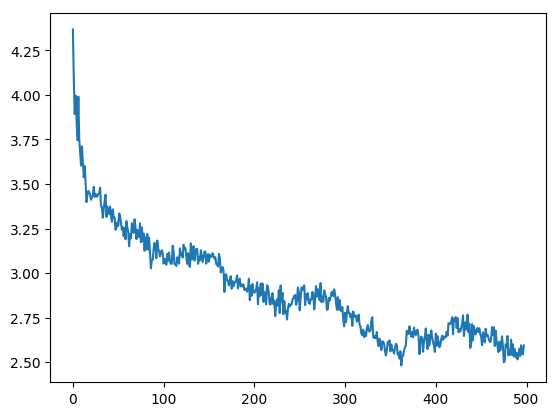

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(loss_list)

## 6. 训练结果与展示：

### 训练过程
![](https://ai-studio-static-online.cdn.bcebos.com/870e8e440d4744c69ca10a3c80db77684227c25ae1c14d2e9ae88b25ffea32be)


### 最终下棋的效果
![](https://ai-studio-static-online.cdn.bcebos.com/225bd09c070c4177814a408689cb45c0ac8ca042f4e74e81897fc41cb79bc833)
